# KNN classifier

In [9]:
import pandas as pd

df = pd.read_csv('dataset-modified.csv', index_col=0)
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)
validation_df = pd.read_csv('validation.csv', index_col=0)

## Split the features and the target column and normalize the data

In [10]:
# full dataset
X = df.drop('Class', axis=1)
y = df['Class']

# splits
X_train = train_df.drop('Class', axis=1)
y_train = train_df['Class']
X_validation = validation_df.drop('Class', axis=1)
y_validation = validation_df['Class']
X_test = test_df.drop('Class', axis=1)
y_test = test_df['Class']

## Experiment with parameters (find optimal k)

The optimal number of neighbors is: 12
The optimal number of neighbors based on AUC is: 28


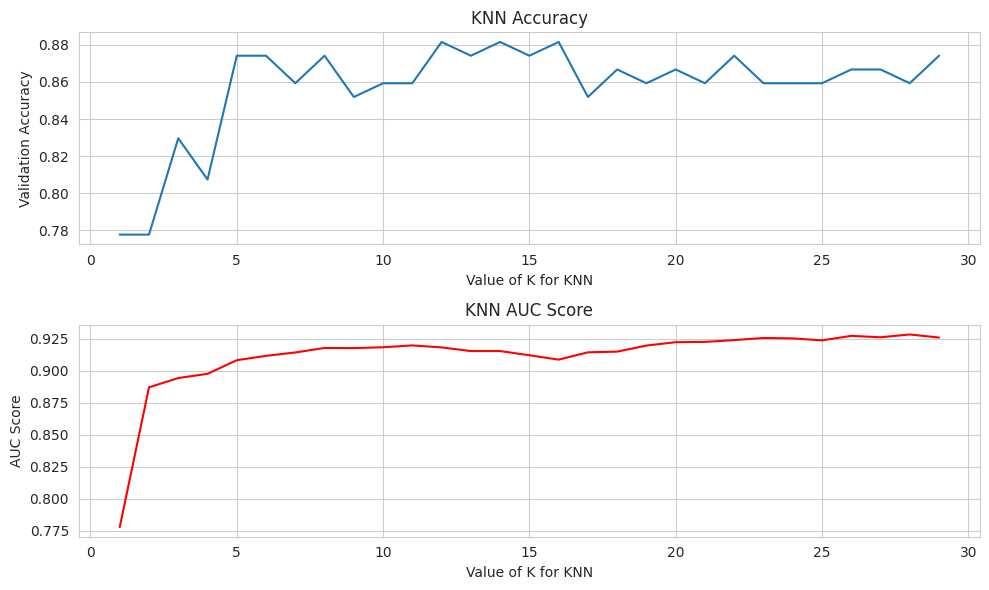

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

validation_scores = []
auc_scores = []

k_values = range(1, 30)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)

    y_pred = knn.predict(X_validation)
    y_pred_prob = knn.predict_proba(X_validation)[:, 1]

    accuracy = accuracy_score(y_validation, y_pred)
    auc = roc_auc_score(y_validation, y_pred_prob)

    validation_scores.append(accuracy)
    auc_scores.append(auc)

plt.figure(figsize=(10, 6))

optimal_n = k_values[np.argmax(validation_scores)]
optimal_n_auc = k_values[np.argmax(auc_scores)]
print("The optimal number of neighbors is:", optimal_n)
print("The optimal number of neighbors based on AUC is:", optimal_n_auc)

plt.subplot(2, 1, 1)
plt.plot(k_values, validation_scores, label='Accuracy')
plt.xlabel('Value of K for KNN')
plt.ylabel('Validation Accuracy')
plt.title('KNN Accuracy')

plt.subplot(2, 1, 2)
plt.plot(k_values, auc_scores, label='AUC', color='red')
plt.xlabel('Value of K for KNN')
plt.ylabel('AUC Score')
plt.title('KNN AUC Score')

plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier


def get_result_stats(clf, X, y, pos_label="Kecimen"):
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)[:, 1]

    conf_matrix = confusion_matrix(y, y_pred, labels=["Kecimen", "Besni"])
    acc = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_prob)
    precision = precision_score(y, y_pred, pos_label=pos_label)
    recall = recall_score(y, y_pred, pos_label=pos_label)
    f1 = f1_score(y, y_pred, pos_label=pos_label)

    return y_pred, acc, auc_score, precision, recall, f1, conf_matrix


dtype = {"K": int, "Accuracy": float, "AUC": float, "Precision": float, "Recall": float, "F1 Score": float}
results_df = pd.DataFrame(columns=["K", "Accuracy", "AUC", "Precision", "Recall", "F1 Score"]).astype(dtype)
wrong_predictions = set()
for val in [2, 12, 28]:
    clf = KNeighborsClassifier(n_neighbors=val).fit(X_train, y_train)
    y_pred, acc, auc_score, precision, recall, f1, conf_matrix = get_result_stats(clf, X_test, y_test)

    df_conf_matrix = pd.DataFrame(conf_matrix, index=["Actual Kecimen", "Actual Besni"],
                                  columns=["Predicted Kecimen", "Predicted Besni"])
    display(df_conf_matrix)

    temp_df = pd.DataFrame([[val, acc, auc_score, precision, recall, f1]],
                           columns=["K", "Accuracy", "AUC", "Precision", "Recall", "F1 Score"]).astype(dtype)
    results_df = pd.concat([results_df, temp_df])

    for i, (item_index, actual) in enumerate(y_test.items()):
        predicted = y_pred[i]
        if actual != predicted:
            wrong_predictions.add(index)

results_df.to_latex(
    f"./knn-scores.tex",
    float_format="%.3f",
    caption=f"Apskaičiuoti matai",
    label=f"tab:knn-scores",
    index=False,
    escape=True,
    bold_rows=True,
)

display(results_df)


,Predicted Kecimen,Predicted Besni
Actual Kecimen,41,31
Actual Besni,7,56


,Predicted Kecimen,Predicted Besni
Actual Kecimen,56,16
Actual Besni,9,54


,Predicted Kecimen,Predicted Besni
Actual Kecimen,59,13
Actual Besni,9,54


,K,Accuracy,AUC,Precision,Recall,F1 Score
0,2,0.718519,0.834877,0.854167,0.569444,0.683333
0,12,0.814815,0.876874,0.861538,0.777778,0.817518
0,28,0.837037,0.913690,0.867647,0.819444,0.842857


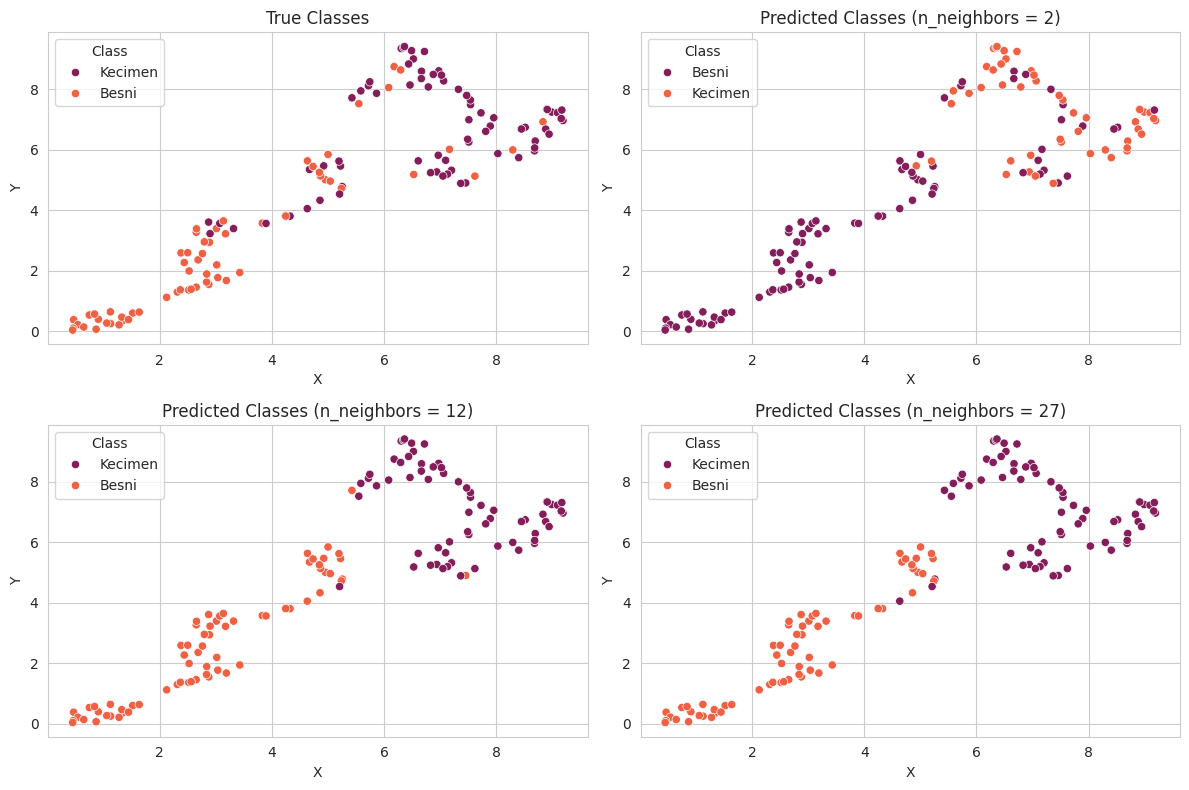

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


def plot_classes_scatterplot(n_neighbors: int, ax):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    y_test_pred = knn.predict(X_test)

    umap_reducer = umap.UMAP(n_neighbors=20, random_state=42, n_jobs=1)
    X_test_umap = umap_reducer.fit_transform(X_test)

    df_pred = pd.DataFrame(data={'UMAP1': X_test_umap[:, 0], 'UMAP2': X_test_umap[:, 1], 'Class': y_test_pred})

    sns.scatterplot(data=df_pred, x='UMAP1', y='UMAP2', hue='Class', palette="rocket", ax=ax)
    ax.set_title(f'Predicted Classes (n_neighbors = {n_neighbors})')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(title='Class', loc='upper left')


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

umap_reducer = umap.UMAP(n_neighbors=20, random_state=42, n_jobs=1)
X_test_umap = umap_reducer.fit_transform(X_test)

df_true = pd.DataFrame(data={'UMAP1': X_test_umap[:, 0], 'UMAP2': X_test_umap[:, 1], 'Class': y_test})
sns.scatterplot(data=df_true, x='UMAP1', y='UMAP2', hue='Class', palette="rocket", ax=axs[0])
axs[0].set_title('True Classes')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].legend(title='Class', loc='upper left')

for n, ax in zip([2, 12, 27], axs[1:]):
    plot_classes_scatterplot(n_neighbors=n, ax=ax)

plt.tight_layout()
plt.show()

In [14]:
def display_stats_tables_by_class(df: pd.DataFrame, label: str):
    rename_map = {
        "mean": "Mean",
        "std": "Std",
        "min": "Min",
        "50%": "Med",
        "25%": "1Q",
        "75%": "3Q",
        "max": "Max",
        "count": "Count"
    }

    for cn in ["Kecimen", "Besni"]:
        stat_df = (
            df.loc[df["Class"] == cn].describe().T.rename(columns=rename_map).T
        )

        stat_df.to_latex(
            f"./stat-{cn.lower()}-knn.tex",
            float_format="%.3f",
            caption=f"Klasės {cn} aprašomoji statistika",
            label=f"tab:knn-{label}-{cn.lower()}",
            escape=True,
            bold_rows=True,
        )

        print(f"Klasės {cn} aprašomoji statistika")
        display(stat_df)


display_stats_tables_by_class(df=test_df.loc[list(wrong_predictions)], label="stat-wrong")


Klasės Kecimen aprašomoji statistika


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Perimeter
Count,1.000000,1.000000,1.000000,1.000000,1.000000
Mean,0.176266,0.158955,0.255646,0.643975,0.173366
Std,NaN,NaN,NaN,NaN,NaN
Min,0.176266,0.158955,0.255646,0.643975,0.173366
1Q,0.176266,0.158955,0.255646,0.643975,0.173366
Med,0.176266,0.158955,0.255646,0.643975,0.173366
3Q,0.176266,0.158955,0.255646,0.643975,0.173366
Max,0.176266,0.158955,0.255646,0.643975,0.173366


Klasės Besni aprašomoji statistika


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Perimeter
Count,0.0,0.0,0.0,0.0,0.0
Mean,NaN,NaN,NaN,NaN,NaN
Std,NaN,NaN,NaN,NaN,NaN
Min,NaN,NaN,NaN,NaN,NaN
1Q,NaN,NaN,NaN,NaN,NaN
Med,NaN,NaN,NaN,NaN,NaN
3Q,NaN,NaN,NaN,NaN,NaN
Max,NaN,NaN,NaN,NaN,NaN
